# Imports and Numba Utility Functions

This section includes the necessary imports and small Numba-optimized utility functions (e.g., utility computation, binomial sampling) used in the Q-learning implementation.

In [158]:
import numpy as np
import pandas as pd
import unittest
import matplotlib.pyplot as plt
from numba import njit

@njit
def compute_utility(w, risk_averse):
    """
    Compute the utility of wealth using an exponential utility function.
    
    Args:
        w (float): Current wealth value.
        risk_averse (float): Risk aversion parameter; if 0, returns wealth directly.
    
    Returns:
        float: Utility value, adjusted for risk aversion.
    """
    if risk_averse != 0:
        return (1 - np.exp(-risk_averse * w)) / risk_averse
    else:
        return w

@njit
def sample_binomial(random_value, p, a, b):
    """
    Sample a binomial return based on a random value.
    
    Args:
        random_value (float): Random number between 0 and 1.
        p (float): Probability of the high return (a).
        a (float): High return value.
        b (float): Low return value.
    
    Returns:
        float: Either `a` (if random_value < p) or `b` (otherwise).
    """
    return a if random_value < p else b

@njit
def compute_mean(arr, count):
    """
    Compute the mean of an array up to a specified count using Numba.
    
    Args:
        arr (np.ndarray): Input array (float32).
        count (int): Number of elements to average.
    
    Returns:
        float: Mean of the first `count` elements; 0.0 if count is 0.
    """
    if count == 0:
        return np.float32(0.0)
    total = np.float32(0.0)
    for i in range(count):
        total += arr[i]
    return total / np.float32(count)

# Numba-Optimized Functions (Q-Learning)

These Numba-optimized functions are tailored for the Q-learning process, handling the MDP step, action selection, theoretical difference calculation, and Q-table updates.

In [221]:
@njit
def mdp_step_jit(wealth_idx, time_step, action, random_value, wealth_levels, alloc_actions, rf, p, a, b, risk_averse, steps, wealth_step):
    """
    Execute one step of the MDP for Q-learning, updating wealth and time.
    
    Args:
        wealth_idx (int): Index of current wealth in wealth_levels array.
        time_step (int): Current time step (0 to steps-1).
        action (int): Index of allocation action in alloc_actions array.
        random_value (float): Random number between 0 and 1 for binomial sampling.
        wealth_levels (np.ndarray): Array of discretized wealth levels (float32).
        alloc_actions (np.ndarray): Array of possible allocation fractions (float32).
        rf (float): Risk-free rate.
        p (float): Probability of high return.
        a (float): High return value.
        b (float): Low return value.
        risk_averse (float): Risk aversion parameter for utility.
        steps (int): Total number of time steps in the episode.
        wealth_step (float): Step size between wealth levels.
    
    Returns:
        tuple: (next_wealth_idx, next_time, reward, done)
            - next_wealth_idx (int): Index of next wealth level.
            - next_time (int): Next time step.
            - reward (float): Utility-based reward (non-zero only at final step).
            - done (bool): Whether the episode is complete.
    """
    current_wealth = wealth_levels[wealth_idx]
    alloc = alloc_actions[action]  # Fraction of wealth allocated to risky asset
    risky_return = sample_binomial(random_value, p, a, b)  # Sample risky asset return
    next_wealth = current_wealth * (1 + rf + alloc * (risky_return - rf))
    next_time = time_step + 1
    # Reward is utility of wealth at final step, otherwise 0
    reward = compute_utility(next_wealth, risk_averse) if next_time >= steps else 0.0
    done = next_time >= steps
    # Convert next_wealth to index, clamping to valid range
    next_wealth_idx = int(round(next_wealth / wealth_step))
    next_wealth_idx = min(max(next_wealth_idx, 0), len(wealth_levels) - 1)
    return next_wealth_idx, next_time, reward, done

@njit
def get_action_jit(wealth_idx, time_step, random_value, epsilon, q_table, num_actions):
    """
    Select an action using an epsilon-greedy policy for Q-learning.
    
    Args:
        wealth_idx (int): Index of current wealth in Q-table.
        time_step (int): Current time step.
        random_value (float): Random number between 0 and 1 for exploration.
        epsilon (float): Exploration probability (0 to 1).
        q_table (np.ndarray): Q-table with shape (wealth_levels, steps, actions).
        num_actions (int): Number of possible actions.
    
    Returns:
        int: Selected action index.
    """
    if random_value < epsilon:
        # Exploration: choose a random action
        return np.random.randint(0, num_actions)
    # Exploitation: choose action with highest Q-value
    return np.argmax(q_table[wealth_idx, time_step])

@njit
def get_step_theo_diff_jit(wealth_idx, time_step, alloc, wealth_levels, p, a, b, rf, risk_averse, steps):
    """
    Calculate the absolute difference between actual and theoretical allocation.
    
    Args:
        wealth_idx (int): Index of current wealth in wealth_levels array.
        time_step (int): Current time step.
        alloc (float): Actual allocation fraction used.
        wealth_levels (np.ndarray): Array of discretized wealth levels (float32).
        p (float): Probability of high return.
        a (float): High return value.
        b (float): Low return value.
        rf (float): Risk-free rate.
        risk_averse (float): Risk aversion parameter.
        steps (int): Total number of time steps.
    
    Returns:
        float: Absolute difference between actual and theoretical allocation.
    """
    current_wealth = wealth_levels[wealth_idx]
    # Cast inputs to float32 for Numba compatibility and consistency with wealth_levels
    p = np.float32(p)
    a = np.float32(a)
    b = np.float32(b)
    rf = np.float32(rf)
    risk_averse = np.float32(risk_averse)
    steps = np.float32(steps)
    time_step = np.float32(time_step)
    alloc = np.float32(alloc)
    
    # Compute theoretical allocation (step_theo_xt)
    denominator = risk_averse * (np.float32(1.0) + rf) ** (steps - time_step - np.float32(1.0)) * (a - b)
    numerator = p * (a - rf) / (np.float32(1.0) - p) / (rf - b)
    step_theo_xt = np.log(numerator) / denominator  # Theoretical wealth allocation
    if current_wealth != np.float32(0.0):
        temp = step_theo_xt / current_wealth  # Scale by current wealth
        # Clamp theoretical allocation between 0 and 1 using min/max (Numba-friendly)
        step_theo_alloc = max(np.float32(0.0), min(np.float32(1.0), temp))
    else:
        step_theo_alloc = np.float32(0.0)  # Avoid division by zero
    return abs(alloc - step_theo_alloc)

@njit
def update_q_value_jit(wealth_idx, time_step, action, reward, next_wealth_idx, next_time, q_table, num_states0, num_states1, 
                       learning_rate, gamma, state_indices, action_indices, state_weights, action_weights):
    """
    Update the Q-table using Q-learning with smoothing over nearby states and actions.
    
    Args:
        wealth_idx (int): Index of current wealth in Q-table.
        time_step (int): Current time step.
        action (int): Chosen action index.
        reward (float): Immediate reward from the environment.
        next_wealth_idx (int): Index of next wealth in Q-table.
        next_time (int): Next time step.
        q_table (np.ndarray): Q-table with shape (wealth_levels, steps, actions).
        num_states0 (int): Number of wealth levels (q_table.shape[0]).
        num_states1 (int): Number of time steps (q_table.shape[1]).
        learning_rate (float): Learning rate for Q-value updates.
        gamma (float): Discount factor for future rewards.
        state_indices (np.ndarray): Array of relative state indices for smoothing (e.g., -5 to 5).
        action_indices (np.ndarray): Array of relative action indices for smoothing (e.g., -1 to 1).
        state_weights (np.ndarray): Weights for state smoothing (Gaussian decay).
        action_weights (np.ndarray): Weights for action smoothing (Gaussian decay).
    
    Returns:
        float: Temporal difference (TD) error for monitoring convergence.
    """
    current_q = q_table[wealth_idx, time_step, action]
    # Q-learning: use max Q-value of next state (off-policy)
    next_max_q = np.max(q_table[next_wealth_idx, next_time]) if next_time < num_states1 else np.float32(0.0)
    target = reward + gamma * next_max_q  # Bellman equation target
    td_error = target - current_q  # Temporal difference error

    # Smooth Q-value updates over nearby states and actions
    for i in range(len(state_indices)):
        state_idx = wealth_idx + state_indices[i]  # Offset current wealth index
        if state_idx >= 0 and state_idx < num_states0:  # Check bounds
            state_weight = state_weights[i]  # Gaussian weight for this state offset
            for j in range(len(action_indices)):
                act_idx = action + action_indices[j]  # Offset current action
                if act_idx >= 0 and act_idx < q_table.shape[2]:  # Check bounds
                    action_weight = action_weights[j]  # Gaussian weight for this action offset
                    total_weight = state_weight * action_weight  # Combined weight
                    # Update Q-value with weighted TD error
                    q_table[state_idx, time_step, act_idx] += learning_rate * total_weight * td_error

    return td_error

# Q-Learning Environment and Distribution

This section defines the `BinomialReturn` class for risky asset returns and the `AssetAllocationEnvironment` class, specific to the Q-learning implementation.

In [160]:
class BinomialReturn:
    """Class to represent binomial returns for the risky asset in Q-learning."""
    def __init__(self, p, a, b):
        """
        Initialize binomial return distribution.
        
        Args:
            p (float): Probability of high return.
            a (float): High return value.
            b (float): Low return value.
        """
        self.p = p
        self.a = a
        self.b = b

    def sample(self, random_values):
        """
        Sample a return using the binomial distribution.
        
        Args:
            random_values (float or np.ndarray): Random number(s) between 0 and 1.
        
        Returns:
            float: Sampled return (a or b).
        """
        return sample_binomial(random_values, self.p, self.a, self.b)

class AssetAllocationEnvironment:
    """Environment class for Q-learning asset allocation problem."""
    def __init__(self, steps, rf, risky_dist, risk_averse, max_wealth, wealth_levels_num, num_actions):
        """
        Initialize the Q-learning environment.
        
        Args:
            steps (int): Number of time steps in an episode.
            rf (float): Risk-free rate.
            risky_dist (BinomialReturn): Risky asset return distribution.
            risk_averse (float): Risk aversion parameter.
            max_wealth (float): Maximum wealth level for discretization.
            wealth_levels_num (int): Number of discrete wealth levels.
            num_actions (int): Number of discrete allocation actions.
        """
        self.steps = steps
        self.rf = rf
        self.risky_dist = risky_dist
        self.risk_averse = risk_averse
        # Discretize wealth from 0 to max_wealth
        self.wealth_levels = np.linspace(0, max_wealth, wealth_levels_num, dtype=np.float32)
        # Discretize allocation from 0 to 1, rounded to 2 decimals
        self.alloc_actions = np.linspace(0, 1, num_actions, dtype=np.float32).round(2)
        self.wealth_step = max_wealth / (wealth_levels_num - 1)  # Step size for wealth discretization

    def mdp_step(self, state, action, random_value):
        """
        Perform one step in the MDP.
        
        Args:
            state (tuple): (wealth_idx, time_step) - current state.
            action (int): Index of allocation action.
            random_value (float): Random number for binomial sampling.
        
        Returns:
            tuple: (next_state, reward, done)
                - next_state (tuple): (next_wealth_idx, next_time).
                - reward (float): Utility-based reward.
                - done (bool): Whether the episode is complete.
        """
        wealth_idx, time_step = state
        next_wealth_idx, next_time, reward, done = mdp_step_jit(
            wealth_idx, time_step, action, random_value, self.wealth_levels, self.alloc_actions,
            self.rf, self.risky_dist.p, self.risky_dist.a, self.risky_dist.b, self.risk_averse,
            self.steps, self.wealth_step
        )
        return (next_wealth_idx, next_time), reward, done

    def get_initial_state(self):
        """
        Generate an initial state with wealth between 1.0 and 2.0.
        
        Returns:
            tuple: (initial_wealth_idx, 0) - initial state.
        
        Raises:
            ValueError: If no wealth levels are between 1.0 and 2.0.
        """
        valid_indices = np.where((self.wealth_levels >= 1.0) & (self.wealth_levels <= 2.0))[0]
        if len(valid_indices) == 0:
            raise ValueError("No wealth levels found between 1 and 2.")
        initial_wealth_idx = np.random.choice(valid_indices)  # Randomly select from valid range
        return (initial_wealth_idx, 0)

    def get_step_theo_diff(self, state, alloc):
        """
        Compute the theoretical allocation difference for a given state and action.
        
        Args:
            state (tuple): (wealth_idx, time_step) - current state.
            alloc (float): Actual allocation fraction.
        
        Returns:
            float: Absolute difference between actual and theoretical allocation.
        """
        wealth_idx, time_step = state
        return get_step_theo_diff_jit(
            wealth_idx, time_step, alloc, self.wealth_levels, self.risky_dist.p,
            self.risky_dist.a, self.risky_dist.b, self.rf, self.risk_averse, self.steps
        )

# Q-Learning Agent

The `QLearningAgent` class implements the Q-learning algorithm, managing the Q-table, action selection (epsilon-greedy), and Q-value updates with smoothing.

In [220]:
class QLearningAgent:
    """Agent class for Q-learning with smoothed Q-value updates."""
    def __init__(self, num_states, num_actions, episodes, learning_rate=0.2, gamma=1.0, epsilon=0.1, epsilon_min=0.01, epsilon_decay_start=500, epsilon_decay_stop=1000):
        """
        Initialize the Q-learning agent.
        
        Args:
            num_states (tuple): (wealth_levels, steps) - state space dimensions.
            num_actions (int): Number of discrete actions.
            episodes (int): Total number of training episodes.
            learning_rate (float): Learning rate for Q-value updates (default: 0.2).
            gamma (float): Discount factor (default: 1.0).
            epsilon (float): Initial exploration probability (default: 0.1).
            epsilon_min (float): Minimum exploration probability (default: 0.01).
            epsilon_decay_start (int): Episode to start epsilon decay (default: 500).
            epsilon_decay_stop (int): Episode to stop epsilon decay (default: 1000).
        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.episodes = episodes
        self.learning_rate = np.float32(learning_rate)  # Cast to float32 for Numba
        self.gamma = np.float32(gamma)  # Cast to float32 for Numba
        self.epsilon = epsilon
        self.epsilon_decay_start = epsilon_decay_start
        self.epsilon_decay_stop = epsilon_decay_stop
        # Linear decay rate for epsilon
        self.epsilon_decay_amount = (epsilon - epsilon_min) / (epsilon_decay_stop - epsilon_decay_start)
        # Q-table: (wealth levels, time steps, actions)
        self.q_table = np.zeros((num_states[0], num_states[1], num_actions), dtype=np.float32)
        self.state_window = 5  # Window size for state smoothing (±5 wealth levels)
        self.action_window = 1  # Window size for action smoothing (±1 action)
        # Indices for smoothing: e.g., [-5, -4, ..., 4, 5]
        self.state_indices = np.arange(-self.state_window, self.state_window + 1, dtype=np.int32)
        self.action_indices = np.arange(-self.action_window, self.action_window + 1, dtype=np.int32)
        # Gaussian weights for smoothing (decay with distance)
        self.state_weights = np.exp(-(self.state_indices ** 2) * 0.1).astype(np.float32)
        self.action_weights = np.exp(-(self.action_indices ** 2) * 0.8).astype(np.float32)

    def get_action(self, state, random_value):
        """
        Select an action for the given state using epsilon-greedy policy.
        
        Args:
            state (tuple): (wealth_idx, time_step) - current state.
            random_value (float): Random number for exploration.
        
        Returns:
            int: Action index.
        """
        wealth_idx, time_step = state
        return get_action_jit(wealth_idx, time_step, random_value, self.epsilon, self.q_table, self.num_actions)

    def update_q_value(self, state, action, reward, next_state):
        """
        Update Q-values based on the observed transition.
        
        Args:
            state (tuple): (wealth_idx, time_step) - current state.
            action (int): Chosen action.
            reward (float): Immediate reward.
            next_state (tuple): (next_wealth_idx, next_time) - next state.
        
        Returns:
            float: TD error for monitoring.
        """
        wealth_idx, time_step = state
        next_wealth_idx, next_time = next_state
        return update_q_value_jit(
            wealth_idx, time_step, action, reward, next_wealth_idx, next_time, self.q_table,
            self.num_states[0], self.num_states[1], self.learning_rate, self.gamma,
            self.state_indices, self.action_indices, self.state_weights, self.action_weights
        )

# Q-Learning Training Loop

This section contains the `train_q_learning` function, which runs the Q-learning algorithm over multiple episodes, tracking theoretical differences and TD errors. It is separated from the setup to allow multiple configurations.

In [162]:
def train_q_learning(env, agent):
    """
    Train the Q-learning agent over a specified number of episodes.
    
    Args:
        env (AssetAllocationEnvironment): Q-learning environment instance.
        agent (QLearningAgent): Q-learning agent instance.
    
    Returns:
        tuple: (step_theo_diff_history, td_error_history, final_utility_history, avg_risky_action_history)
            - step_theo_diff_history (np.ndarray): Average theoretical diff per episode.
            - td_error_history (np.ndarray): Average TD error per episode.
            - final_utility_history (np.ndarray): Final utility at the end of each episode.
            - avg_risky_action_history (np.ndarray): Average risky asset allocation per episode.
    """
    # Arrays to store average metrics per episode
    step_theo_diff_history = np.zeros(agent.episodes, dtype=np.float32)
    td_error_history = np.zeros(agent.episodes, dtype=np.float32)
    final_utility_history = np.zeros(agent.episodes, dtype=np.float32)  # New: Final utility per episode
    avg_risky_action_history = np.zeros(agent.episodes, dtype=np.float32)  # New: Avg risky action per episode
    # Pre-generate random values for all episodes and steps (2 per step: action + return)
    random_values = np.random.random((agent.episodes, env.steps * 2)).astype(np.float32)

    for episode in range(agent.episodes):
        state = env.get_initial_state()  # Start with random wealth between 1.0 and 2.0
        # Temporary arrays for per-step metrics within an episode
        episode_theo_diffs = np.zeros(env.steps, dtype=np.float32)
        episode_td_errors = np.zeros(env.steps, dtype=np.float32)
        episode_actions = np.zeros(env.steps, dtype=np.float32)  # New: Store risky allocations per step
        step_count = 0
        done = False
        random_idx = 0  # Index into random_values for this episode

        while not done:
            if random_idx >= env.steps * 2:
                # Safety check: ensure we don’t exceed pre-allocated random values
                raise ValueError(f"random_idx {random_idx} exceeds random_values bounds {env.steps * 2} for episode {episode}")
            # Use first random value for action selection
            action = agent.get_action(state, random_values[episode, random_idx])
            random_idx += 1
            # Use second random value for environment step
            next_state, reward, done = env.mdp_step(state, action, random_values[episode, random_idx])
            random_idx += 1
            # Update Q-table and get TD error
            td_error = agent.update_q_value(state, action, reward, next_state)
            episode_td_errors[step_count] = abs(td_error)  # Store absolute TD error
            alloc = env.alloc_actions[action]  # Actual allocation fraction (0 to 1)
            episode_actions[step_count] = alloc  # New: Store allocation for averaging later
            theo_diff = env.get_step_theo_diff(state, alloc)  # Compare to theoretical
            episode_theo_diffs[step_count] = theo_diff
            # New: Store final utility when episode ends (reward is non-zero only at final step)
            if done:
                final_utility_history[episode] = reward
            state = next_state
            step_count += 1
        
        # Average metrics over steps in this episode using Numba-optimized compute_mean
        step_theo_diff_history[episode] = compute_mean(episode_theo_diffs, step_count)
        td_error_history[episode] = compute_mean(episode_td_errors, step_count)
        avg_risky_action_history[episode] = compute_mean(episode_actions, step_count)

        # Linearly decay epsilon between start and stop episodes
        agent.epsilon = agent.epsilon - agent.epsilon_decay_amount if (episode >= agent.epsilon_decay_start and episode < agent.epsilon_decay_stop) else agent.epsilon

        # Log progress every 10,000 episodes
        if episode % 10000 == 0 and episode > 0:
            latest_avg_theo_diff = np.mean(step_theo_diff_history[max(0, episode-10000):episode+1])
            latest_avg_td_error = np.mean(td_error_history[max(0, episode-10000):episode+1])
            latest_avg_utility = np.mean(final_utility_history[max(0, episode-10000):episode+1])  # New
            latest_avg_risky = np.mean(avg_risky_action_history[max(0, episode-10000):episode+1])  # New
            print(f"Episode {episode}, Epsilon: {agent.epsilon:.4f}, "
                  f"Avg Theo Diff (last 10k): {latest_avg_theo_diff:.4f}, "
                  f"Avg TD Error (last 10k): {latest_avg_td_error:.4f}, "
                  f"Avg Final Utility (last 10k): {latest_avg_utility:.4f}, "
                  f"Avg Risky Action (last 10k): {latest_avg_risky:.4f}")

    return step_theo_diff_history, td_error_history, final_utility_history, avg_risky_action_history

# Unit Tests for Q Learning

In [222]:
class TestQLearning(unittest.TestCase):
    def setUp(self):
        """Set up common test fixtures."""
        self.p = 0.9
        self.a = 0.1
        self.b = -0.1
        self.steps = 2
        self.rf = 0.01
        self.risk_averse = 0.2
        self.max_wealth = 2.0
        self.wealth_levels_num = 5  # [0, 0.5, 1.0, 1.5, 2.0]
        self.num_actions = 3  # [0, 0.5, 1]
        
        self.wealth_levels = np.linspace(0, self.max_wealth, self.wealth_levels_num, dtype=np.float32)
        self.alloc_actions = np.linspace(0, 1, self.num_actions, dtype=np.float32)
        self.wealth_step = self.max_wealth / (self.wealth_levels_num - 1)
        
        self.risky_dist = BinomialReturn(self.p, self.a, self.b)
        self.env = AssetAllocationEnvironment(
            steps=self.steps, rf=self.rf, risky_dist=self.risky_dist, 
            risk_averse=self.risk_averse, max_wealth=self.max_wealth, 
            wealth_levels_num=self.wealth_levels_num, num_actions=self.num_actions
        )
        self.agent = QLearningAgent(
            num_states=(self.wealth_levels_num, self.steps), num_actions=self.num_actions, 
            episodes=10, learning_rate=0.1, gamma=1.0, epsilon=0.5, epsilon_min=0.1, 
            epsilon_decay_start=0, epsilon_decay_stop=5
        )

    def test_compute_utility(self):
        """Test utility computation for different wealth and risk aversion values."""
        self.assertAlmostEqual(compute_utility(1.0, 0.0), 1.0)
        self.assertAlmostEqual(compute_utility(0.0, 0.2), 0.0)
        u = compute_utility(1.0, 0.2)
        self.assertTrue(0.9 < u < 0.91)

    def test_sample_binomial(self):
        """Test binomial sampling with edge-case random values."""
        self.assertEqual(sample_binomial(0.0, self.p, self.a, self.b), self.a)
        self.assertEqual(sample_binomial(0.95, self.p, self.a, self.b), self.b)

    def test_compute_mean(self):
        """Test Numba mean computation."""
        arr = np.array([1.0, 2.0, 3.0], dtype=np.float32)
        self.assertEqual(compute_mean(arr, 0), 0.0)
        self.assertEqual(compute_mean(arr, 3), 2.0)

    def test_mdp_step_jit(self):
        """Test MDP step with known inputs."""
        wealth_idx, time_step = 2, 0
        action = 2
        random_value = 0.5
        next_idx, next_t, reward, done = mdp_step_jit(
            wealth_idx, time_step, action, random_value, self.wealth_levels, 
            self.alloc_actions, self.rf, self.p, self.a, self.b, self.risk_averse, 
            self.steps, self.wealth_step
        )
        self.assertEqual(next_idx, 2)
        self.assertEqual(next_t, 1)
        self.assertEqual(reward, 0.0)
        self.assertFalse(done)

    def test_get_action_jit(self):
        """Test epsilon-greedy action selection."""
        self.agent.q_table[2, 0, 2] = 1.0
        action = get_action_jit(2, 0, 0.6, self.agent.epsilon, self.agent.q_table, self.num_actions)
        self.assertEqual(action, 2)
        action = get_action_jit(2, 0, 0.1, self.agent.epsilon, self.agent.q_table, self.num_actions)
        self.assertTrue(0 <= action <= 2)

    def test_get_step_theo_diff_jit(self):
        """Test theoretical allocation difference."""
        diff = get_step_theo_diff_jit(2, 0, 1.0, self.wealth_levels, self.p, self.a, self.b, 
                                      self.rf, self.risk_averse, self.steps)
        self.assertTrue(0 <= diff <= 0.2)

    def test_update_q_value_jit(self):
        """Test Q-value update with smoothing."""
        q_table = np.zeros((self.wealth_levels_num, self.steps, self.num_actions), dtype=np.float32)
        td_error = update_q_value_jit(
            2, 0, 2, 1.0, 3, 1, q_table, self.wealth_levels_num, self.steps, 
            self.agent.learning_rate, self.agent.gamma, self.agent.state_indices, 
            self.agent.action_indices, self.agent.state_weights, self.agent.action_weights
        )
        self.assertAlmostEqual(td_error, 1.0)
        self.assertTrue(q_table[2, 0, 2] > 0)

    def test_environment_initial_state(self):
        """Test initial state generation."""
        state = self.env.get_initial_state()
        wealth_idx, time_step = state
        self.assertEqual(time_step, 0)
        self.assertTrue(2 <= wealth_idx <= 4)  # Wealth between 1.0 and 2.0

    def test_train_q_learning(self):
        """Test training loop outputs."""
        step_theo_diff, td_error, final_util, avg_risky = train_q_learning(self.env, self.agent)
        self.assertEqual(step_theo_diff.shape, (10,))
        self.assertEqual(td_error.shape, (10,))
        self.assertEqual(final_util.shape, (10,))
        self.assertEqual(avg_risky.shape, (10,))
        self.assertTrue(np.all(step_theo_diff >= 0))
        self.assertTrue(np.all(avg_risky >= 0) and np.all(avg_risky <= 1))

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.524s

OK


# Q-Learning Setup and Execution (Setup 1: High Risky Allocation)

This section defines the first setup configuration for Q-learning, designed to favor a 100% allocation in the risky asset. With a high probability of positive returns (`p = 0.9`, `a = 0.1`) compared to the risk-free rate (`rf = 0.01`) and a moderate risk aversion (`risk_averse = 0.2`), the risky asset’s expected return (8% per step) significantly outweighs the risk-free alternative, especially over 10 steps. This setup tests whether the Q-learning agent learns to consistently allocate all wealth to the risky asset, as reflected in `avg_risky_action_history` approaching 1.0.

In [164]:
# Initialize q_learning_history for different setups
q_learning_history = {}

In [188]:
# Parameters for Setup 1
p = 0.9  # Probability of high return
a = 0.1  # High return value
b = -0.01  # Low return value
steps = 10  # Number of time steps
rf = 0.01  # Risk-free rate
risk_averse = 0.2 
# Maximum wealth based on max possible growth: 2 * (1 + a)^steps
max_wealth = 2 * (1 + a) ** steps
max_wealth = np.ceil(max_wealth * 10) / 10  # Round up to nearest 0.1
wealth_levels_num = int(max_wealth * 50 + 1)  # Discretize into 50 levels per unit
num_actions = 11  # 11 allocation actions (0 to 1 in steps of 0.1)
learning_rate = 0.003  
gamma = 1.0  
epsilon = 1  # Start fully exploratory
epsilon_min = 0.001  # Minimum exploration rate
epsilon_decay_start = 0  
epsilon_decay_stop = 1000000  
episodes = 1000000  # Total training episodes

# Initialize environment and agent for Setup 1
risky_dist = BinomialReturn(p=p, a=a, b=b)
env = AssetAllocationEnvironment(
    steps=steps, rf=rf, risky_dist=risky_dist, 
    risk_averse=risk_averse, max_wealth=max_wealth, 
    wealth_levels_num=wealth_levels_num, num_actions=num_actions
)
agent = QLearningAgent(
    num_states=(wealth_levels_num, steps), num_actions=num_actions, 
    episodes=episodes, learning_rate=learning_rate, gamma=gamma, 
    epsilon=epsilon, epsilon_min=epsilon_min, 
    epsilon_decay_start=epsilon_decay_start, epsilon_decay_stop=epsilon_decay_stop
)

# Train and store results for Setup 1
q_learning_history[1] = {}
q_learning_history[1]['theoretical_diffs'], q_learning_history[1]['td_errors'], q_learning_history[1]['final_utility'], q_learning_history[1]['actions'] = train_q_learning(env, agent)

Episode 10000, Epsilon: 0.9900, Avg Theo Diff (last 10k): 0.5001, Avg TD Error (last 10k): 0.1960, Avg Final Utility (last 10k): 1.9077, Avg Risky Action (last 10k): 0.4999
Episode 20000, Epsilon: 0.9800, Avg Theo Diff (last 10k): 0.4995, Avg TD Error (last 10k): 0.2034, Avg Final Utility (last 10k): 1.9131, Avg Risky Action (last 10k): 0.5005
Episode 30000, Epsilon: 0.9700, Avg Theo Diff (last 10k): 0.4991, Avg TD Error (last 10k): 0.2111, Avg Final Utility (last 10k): 1.9052, Avg Risky Action (last 10k): 0.5009
Episode 40000, Epsilon: 0.9600, Avg Theo Diff (last 10k): 0.4982, Avg TD Error (last 10k): 0.2209, Avg Final Utility (last 10k): 1.9051, Avg Risky Action (last 10k): 0.5018
Episode 50000, Epsilon: 0.9500, Avg Theo Diff (last 10k): 0.4957, Avg TD Error (last 10k): 0.2343, Avg Final Utility (last 10k): 1.9130, Avg Risky Action (last 10k): 0.5043
Episode 60000, Epsilon: 0.9401, Avg Theo Diff (last 10k): 0.4937, Avg TD Error (last 10k): 0.2505, Avg Final Utility (last 10k): 1.9160

# Q-Learning Setup and Execution (Setup 2: Low Risky Allocation)

In [190]:
# Parameters for Setup 2
p = 0.1  # Probability of high return
a = 0.011  # High return value
b = -0.1  # Low return value
steps = 10  # Number of time steps
rf = 0.01  # Risk-free rate
risk_averse = 0.5
# Maximum wealth based on max possible growth: 2 * (1 + a)^steps
max_wealth = 2 * (1 + a) ** steps
max_wealth = np.ceil(max_wealth * 10) / 10  # Round up to nearest 0.1
wealth_levels_num = int(max_wealth * 50 + 1)  # Discretize into 50 levels per unit
num_actions = 11  # 11 allocation actions (0 to 1 in steps of 0.1)
learning_rate = 0.003
gamma = 1.0  
epsilon = 1  # Start fully exploratory
epsilon_min = 0.001  # Minimum exploration rate
epsilon_decay_start = 0  
epsilon_decay_stop = 1000000  
episodes = 1000000  # Total training episodes

# Initialize environment and agent for Setup 1
risky_dist = BinomialReturn(p=p, a=a, b=b)
env = AssetAllocationEnvironment(
    steps=steps, rf=rf, risky_dist=risky_dist, 
    risk_averse=risk_averse, max_wealth=max_wealth, 
    wealth_levels_num=wealth_levels_num, num_actions=num_actions
)
agent = QLearningAgent(
    num_states=(wealth_levels_num, steps), num_actions=num_actions, 
    episodes=episodes, learning_rate=learning_rate, gamma=gamma, 
    epsilon=epsilon, epsilon_min=epsilon_min, 
    epsilon_decay_start=epsilon_decay_start, epsilon_decay_stop=epsilon_decay_stop
)

# Train and store results for Setup 2
q_learning_history[2] = {}
q_learning_history[2]['theoretical_diffs'], q_learning_history[2]['td_errors'], q_learning_history[2]['final_utility'], q_learning_history[2]['actions'] = train_q_learning(env, agent)

Episode 10000, Epsilon: 0.9900, Avg Theo Diff (last 10k): 0.4990, Avg TD Error (last 10k): 0.0817, Avg Final Utility (last 10k): 0.7825, Avg Risky Action (last 10k): 0.4990
Episode 20000, Epsilon: 0.9800, Avg Theo Diff (last 10k): 0.4993, Avg TD Error (last 10k): 0.0874, Avg Final Utility (last 10k): 0.7822, Avg Risky Action (last 10k): 0.4993
Episode 30000, Epsilon: 0.9700, Avg Theo Diff (last 10k): 0.4966, Avg TD Error (last 10k): 0.0963, Avg Final Utility (last 10k): 0.7855, Avg Risky Action (last 10k): 0.4966
Episode 40000, Epsilon: 0.9600, Avg Theo Diff (last 10k): 0.4963, Avg TD Error (last 10k): 0.1066, Avg Final Utility (last 10k): 0.7850, Avg Risky Action (last 10k): 0.4963
Episode 50000, Epsilon: 0.9500, Avg Theo Diff (last 10k): 0.4976, Avg TD Error (last 10k): 0.1184, Avg Final Utility (last 10k): 0.7856, Avg Risky Action (last 10k): 0.4976
Episode 60000, Epsilon: 0.9401, Avg Theo Diff (last 10k): 0.4972, Avg TD Error (last 10k): 0.1299, Avg Final Utility (last 10k): 0.7847

# Q-Learning Setup and Execution (Setup 3: Dynamic Risky Allocation)

In [226]:
# Parameters for Setup 3
p = 0.7  # Probability of high return
a = 0.3  # High return value
b = -0.3  # Low return value
steps = 10  # Number of time steps
rf = 0.06  # Risk-free rate
risk_averse = 0.4
# Maximum wealth based on max possible growth: 2 * (1 + a)^steps
max_wealth = 2 * (1 + a) ** steps
max_wealth = np.ceil(max_wealth * 10) / 10  # Round up to nearest 0.1
wealth_levels_num = int(max_wealth * 50 + 1)  # Discretize into 50 levels per unit
num_actions = 11  # 11 allocation actions (0 to 1 in steps of 0.1)
learning_rate = 0.003
gamma = 1.0  
epsilon = 1  # Start fully exploratory
epsilon_min = 0.05  # Minimum exploration rate
epsilon_decay_start = 0
epsilon_decay_stop = 1500000  
episodes = 1500000  # Total training episodes

# Initialize environment and agent for Setup 1
risky_dist = BinomialReturn(p=p, a=a, b=b)
env = AssetAllocationEnvironment(
    steps=steps, rf=rf, risky_dist=risky_dist, 
    risk_averse=risk_averse, max_wealth=max_wealth, 
    wealth_levels_num=wealth_levels_num, num_actions=num_actions
)
agent = QLearningAgent(
    num_states=(wealth_levels_num, steps), num_actions=num_actions, 
    episodes=episodes, learning_rate=learning_rate, gamma=gamma, 
    epsilon=epsilon, epsilon_min=epsilon_min, 
    epsilon_decay_start=epsilon_decay_start, epsilon_decay_stop=epsilon_decay_stop
)

# Train and store results for Setup 3
q_learning_history[3] = {}
q_learning_history[3]['theoretical_diffs'], q_learning_history[3]['td_errors'], q_learning_history[3]['final_utility'], q_learning_history[3]['actions'] = train_q_learning(env, agent)

Episode 10000, Epsilon: 0.9937, Avg Theo Diff (last 10k): 0.3509, Avg TD Error (last 10k): 0.1769, Avg Final Utility (last 10k): 1.7462, Avg Risky Action (last 10k): 0.5005
Episode 20000, Epsilon: 0.9873, Avg Theo Diff (last 10k): 0.3525, Avg TD Error (last 10k): 0.1781, Avg Final Utility (last 10k): 1.7326, Avg Risky Action (last 10k): 0.4998
Episode 30000, Epsilon: 0.9810, Avg Theo Diff (last 10k): 0.3528, Avg TD Error (last 10k): 0.1813, Avg Final Utility (last 10k): 1.7381, Avg Risky Action (last 10k): 0.4977
Episode 40000, Epsilon: 0.9747, Avg Theo Diff (last 10k): 0.3514, Avg TD Error (last 10k): 0.1834, Avg Final Utility (last 10k): 1.7361, Avg Risky Action (last 10k): 0.4990
Episode 50000, Epsilon: 0.9683, Avg Theo Diff (last 10k): 0.3515, Avg TD Error (last 10k): 0.1867, Avg Final Utility (last 10k): 1.7420, Avg Risky Action (last 10k): 0.4993
Episode 60000, Epsilon: 0.9620, Avg Theo Diff (last 10k): 0.3525, Avg TD Error (last 10k): 0.1897, Avg Final Utility (last 10k): 1.7370

# Visualization

In [230]:
# Moving Average Utility
def moving_average(data, window_size=500):
    if len(data) < window_size:
        return data
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

# Visualization Function
def visualize_training(results, ma_window=500, show_raw=True, suffix='', save_fig=False):
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    ma_diffs = moving_average(results['theoretical_diffs'], ma_window)
    ma_final_utility = moving_average(results['final_utility'], ma_window)
    ma_actions = moving_average(results['actions'], ma_window)
    ma_td_errors = moving_average(results['td_errors'], ma_window)
    
    ma_episodes = range(ma_window - 1, ma_window - 1 + len(ma_diffs))
    
    # Plot 1: Theoretical difference
    if show_raw:
        axes[0].plot(results['theoretical_diffs'], 'lightgray', alpha=0.4, label='Raw')
    axes[0].plot(ma_episodes, ma_diffs, 'b-', linewidth=2, label=f'Moving Avg ({ma_window} episodes)')
    axes[0].set_title('Difference from Theoretical Optimal')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Average Difference')
    axes[0].legend()
    
    # Plot 2: final_utility
    if show_raw:
        axes[1].plot(results['final_utility'], 'lightgray', alpha=0.4, label='Raw')
    axes[1].plot(ma_episodes, ma_final_utility, 'g-', linewidth=2, label=f'Moving Avg ({ma_window} episodes)')
    axes[1].set_title('Final Utility')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Reward')
    axes[1].legend()
    
    # Plot 3: Actions
    if show_raw:
        axes[2].plot(results['actions'], 'lightgray', alpha=0.4, label='Raw')
    axes[2].plot(ma_episodes, ma_actions, 'r-', linewidth=2, label=f'Moving Avg ({ma_window} episodes)')
    axes[2].set_title('Action Allocation')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Average Allocation')
    axes[2].legend()
    
    # Plot 4: TD Errors
    if show_raw:
        axes[3].plot(results['td_errors'], 'lightgray', alpha=0.4, label='Raw')
    axes[3].plot(ma_episodes, ma_td_errors, 'm-', linewidth=2, label=f'Moving Avg ({ma_window} episodes)')
    axes[3].set_title('TD Error')
    axes[3].set_xlabel('Episode')
    axes[3].set_ylabel('Average TD Error')
    axes[3].legend()
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'training_metrics_ma_{suffix}.png')
    plt.show()

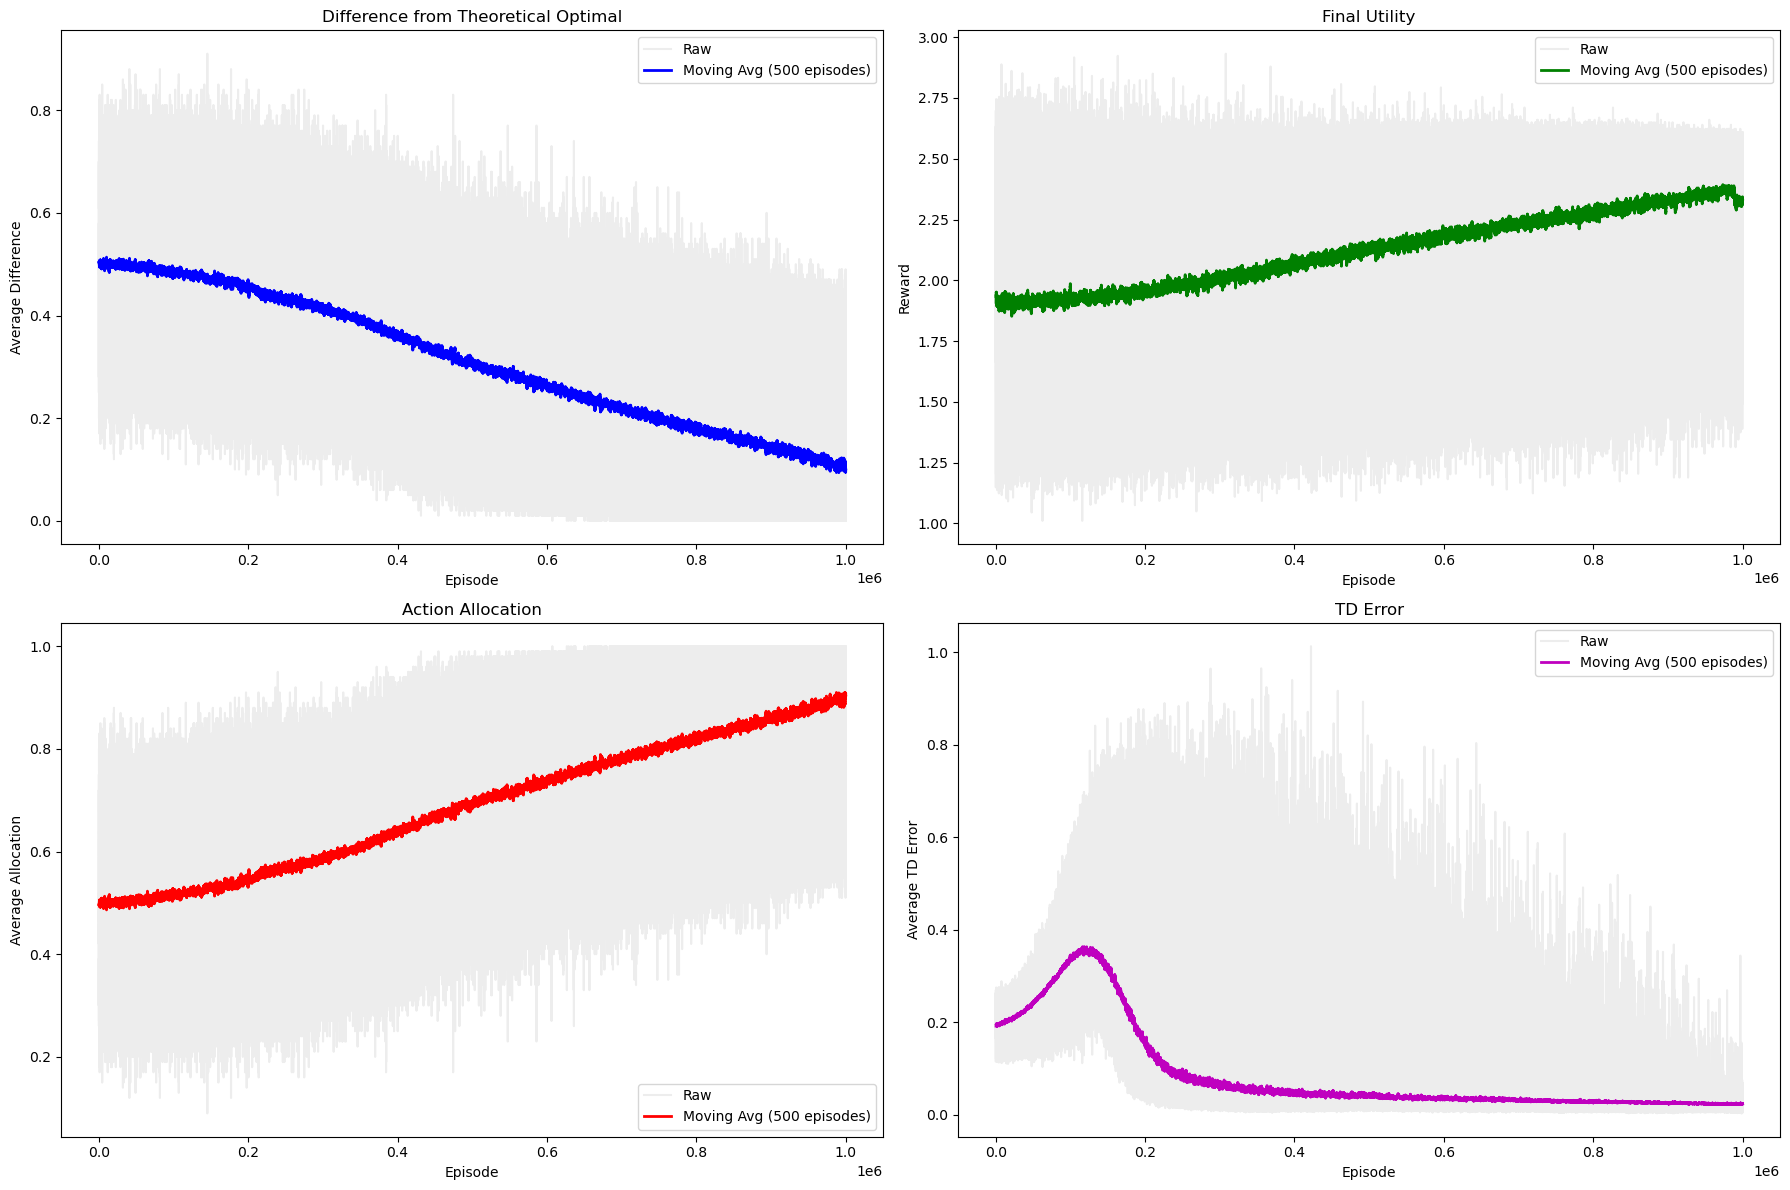

In [239]:
# High risky allocation
visualize_training(q_learning_history[1], ma_window=500, show_raw=True, suffix='high_risk', save_fig=True)

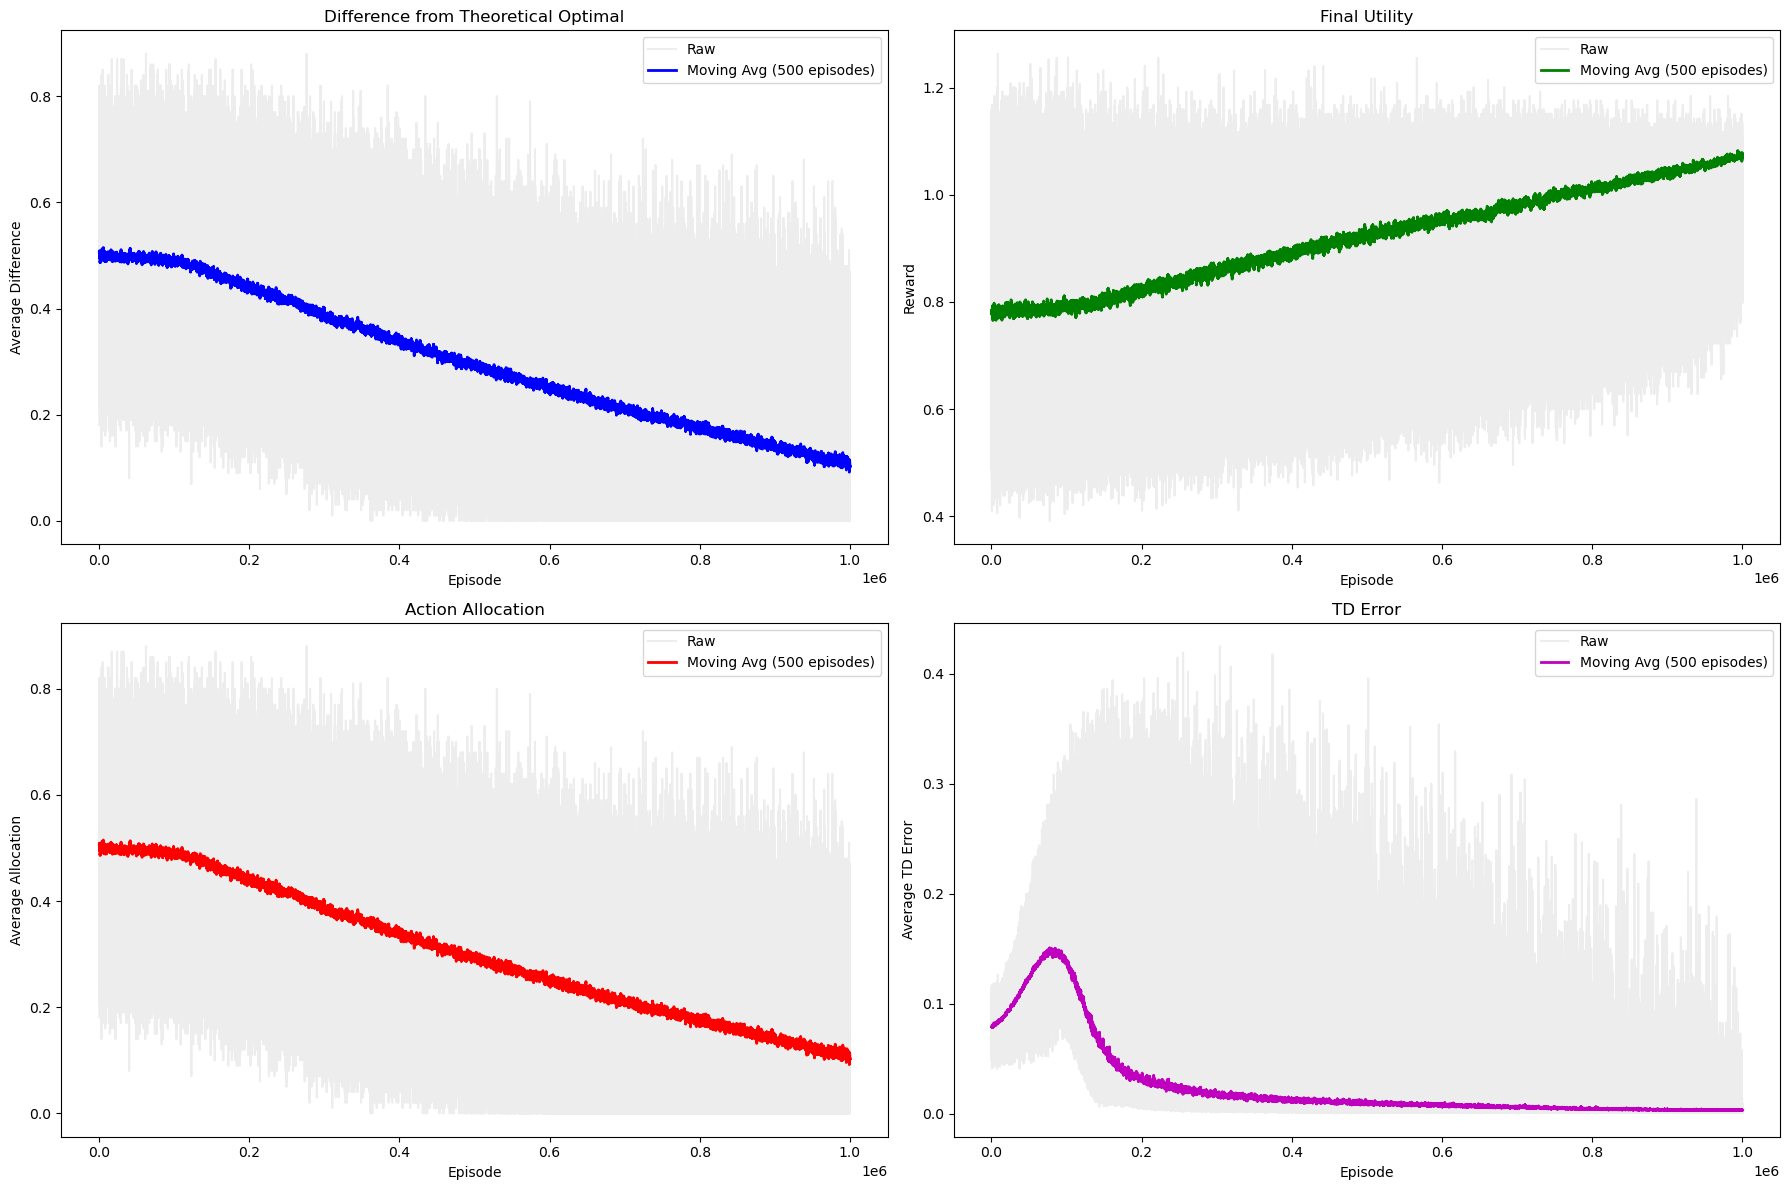

In [240]:
# Low risky allocation
visualize_training(q_learning_history[2], ma_window=500, show_raw=True, suffix='low_risk', save_fig=True)

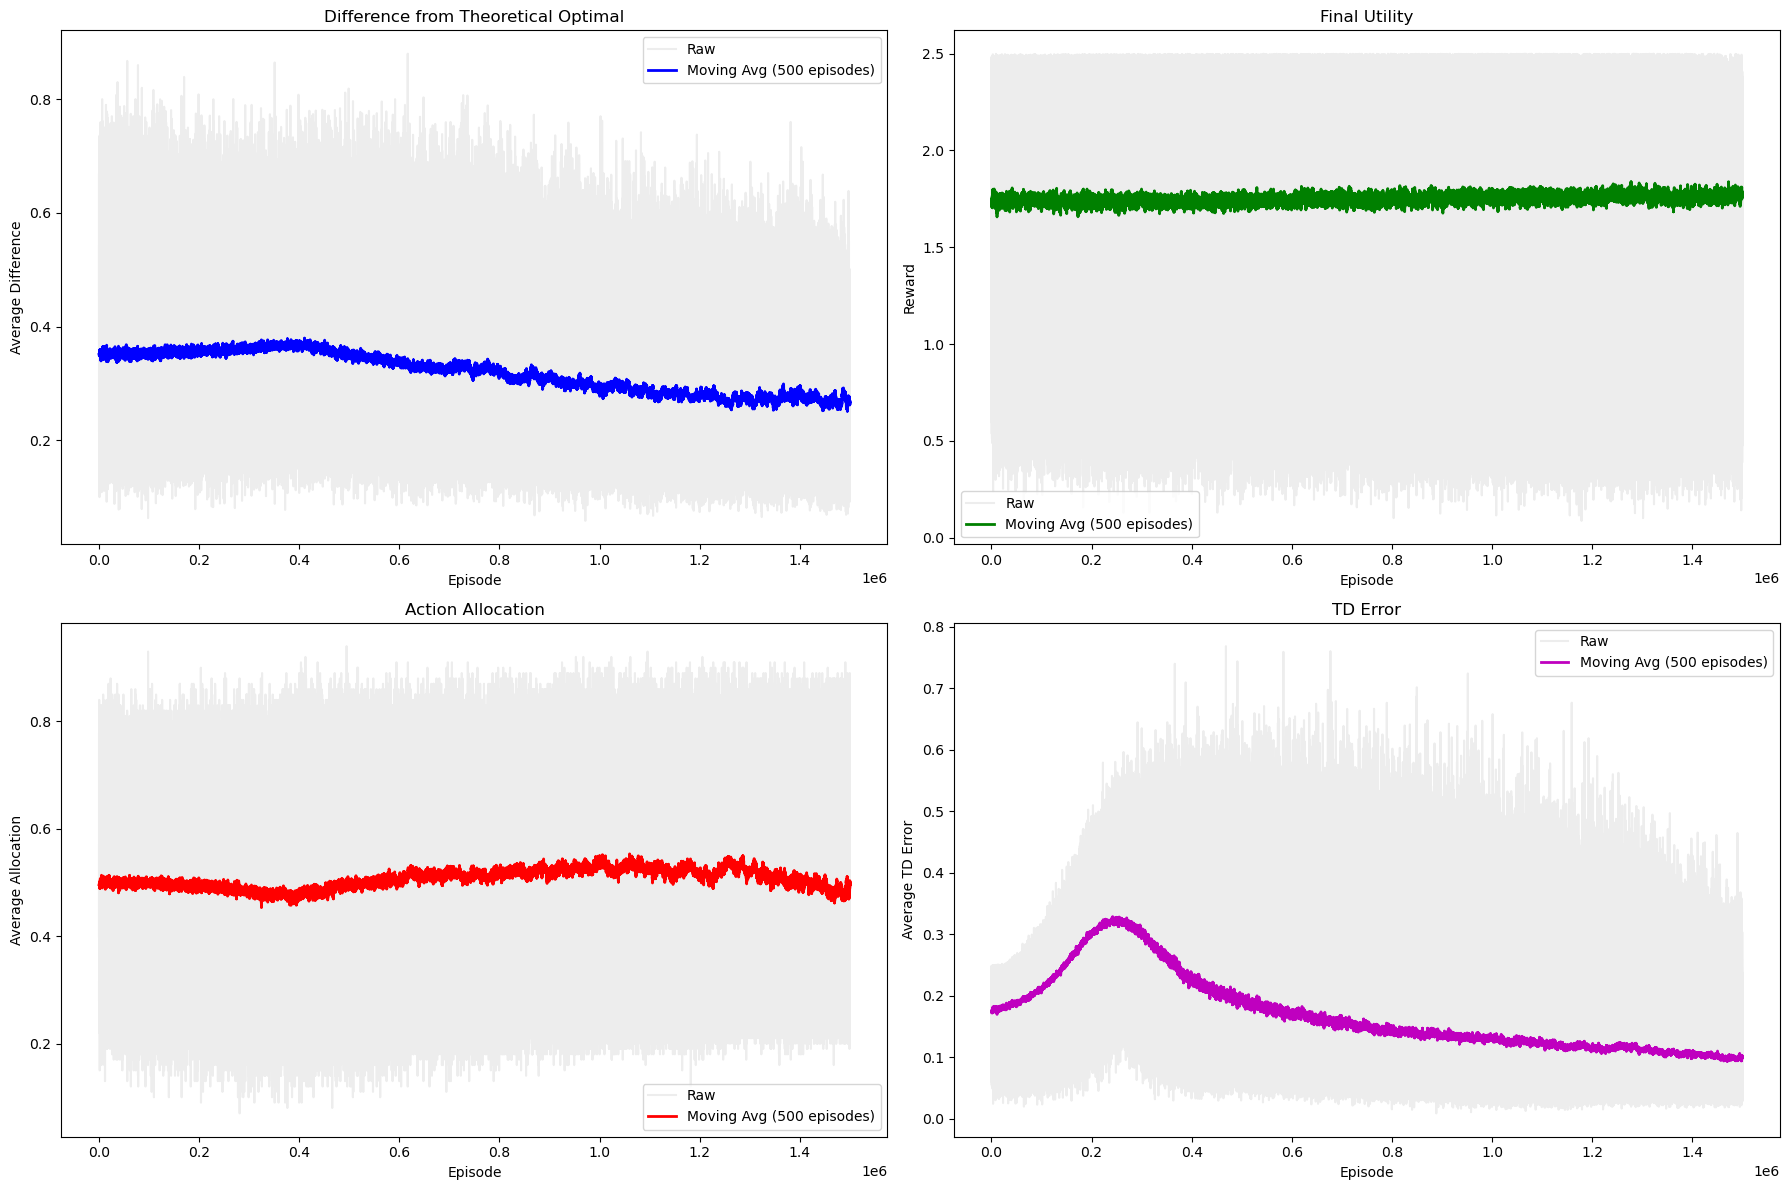

In [241]:
# Dynamic risky allocation
visualize_training(q_learning_history[3], ma_window=500, show_raw=True, suffix='dynamic', save_fig=True)

# Test policy

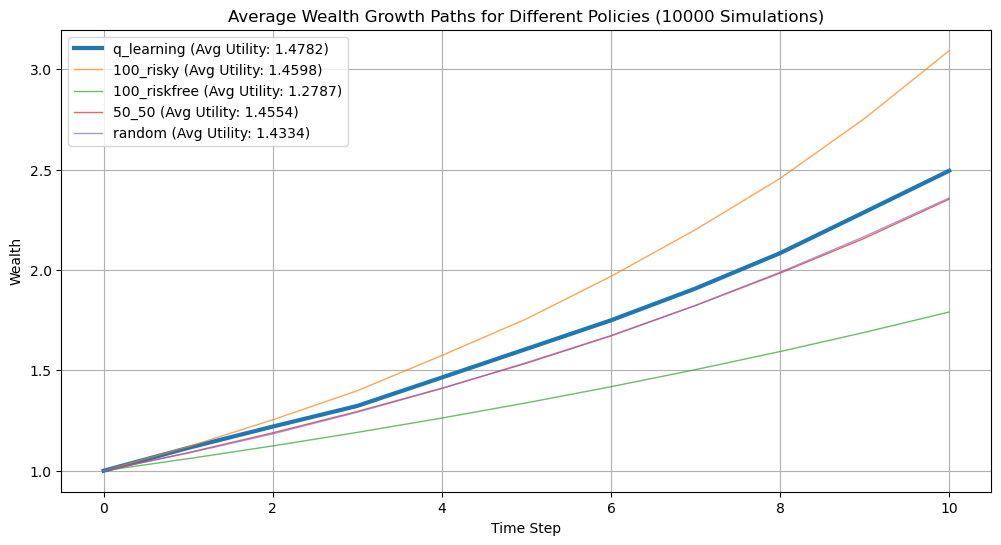

In [244]:
def simulate_policy(env, agent, policy_type, num_simulations=10000, initial_wealth=1):
    """
    Simulate wealth growth trajectories under a specified investment policy.

    Args:
        env : object
            Environment object containing simulation parameters (steps, wealth levels, 
            allocation actions, risk-free rate, and risky asset distribution)
        agent : object
            Agent object containing the trained Q-table for Q-learning policy
        policy_type : str
            Type of investment policy to simulate ('q_learning', '100_risky', 
            '100_riskfree', '50_50', or 'random')
        num_simulations : int, optional
            Number of simulation paths to generate (default: 10000)
        initial_wealth : float, optional
            Starting wealth value for each simulation (default: 1)

    Returns:
        tuple
            - wealth_paths : numpy.ndarray
                Array of shape (num_simulations, steps + 1) containing wealth trajectories
            - utility_values : numpy.ndarray
                Array of shape (num_simulations,) containing utility values for final wealth
    """
    
    # Initialize arrays to store wealth trajectories and utility values
    wealth_paths = np.zeros((num_simulations, env.steps + 1))  # +1 includes initial wealth
    utility_values = np.zeros(num_simulations)
    
    # Run Monte Carlo simulations
    for sim in range(num_simulations):
        wealth = initial_wealth
        wealth_paths[sim, 0] = wealth  # Record initial wealth
        random_values = np.random.random(env.steps)  # Generate random values for sampling
        
        # Simulate wealth evolution over time steps
        for t in range(env.steps):
            # Determine allocation based on policy type
            if policy_type == 'q_learning':
                # Discretize wealth and ensure index is within bounds
                wealth_idx = int(round(wealth / env.wealth_step))
                wealth_idx = min(max(wealth_idx, 0), len(env.wealth_levels) - 1)
                state = (wealth_idx, t)
                # Select optimal action from Q-table
                action = np.argmax(agent.q_table[wealth_idx, t])
                alloc = env.alloc_actions[action]
            elif policy_type == '100_risky':
                alloc = 1.0  # 100% allocation to risky asset
            elif policy_type == '100_riskfree':
                alloc = 0.0  # 100% allocation to risk-free asset
            elif policy_type == '50_50':
                alloc = 0.5  # Equal allocation between risky and risk-free assets
            elif policy_type == 'random':
                alloc = np.random.uniform(0, 1)  # Random allocation between 0 and 1
            
            # Sample risky asset return and update wealth
            risky_return = env.risky_dist.sample(random_values[t])
            wealth = wealth * (1 + env.rf + alloc * (risky_return - env.rf))
            wealth_paths[sim, t + 1] = wealth  # Record wealth at next time step
        
        # Compute utility of final wealth for this simulation
        utility_values[sim] = compute_utility(wealth_paths[sim, -1], env.risk_averse)
    
    return wealth_paths, utility_values


# Run simulations for each policy
policies = ['q_learning', '100_risky', '100_riskfree', '50_50', 'random'] # todo: add sarsa
wealth_paths_dict = {}
utility_dict = {}

for policy in policies:
    wealth_paths, utility_values = simulate_policy(env, agent, policy)
    wealth_paths_dict[policy] = wealth_paths
    utility_dict[policy] = utility_values

# Plotting average wealth paths
plt.figure(figsize=(12, 6))
for policy in policies:
    avg_wealth_path = np.mean(wealth_paths_dict[policy], axis=0)
    if policy in ['100_risky', '100_riskfree', '50_50', 'random']:
        transparency = 0.7
        linewidth = 1
    else:
        transparency = 1
        linewidth = 3
    plt.plot(range(steps + 1), avg_wealth_path, label=f'{policy} (Avg Utility: {np.mean(utility_dict[policy]):.4f})', linewidth=linewidth, alpha=transparency)

plt.xlabel('Time Step')
plt.ylabel('Wealth')
plt.title('Average Wealth Growth Paths for Different Policies (10000 Simulations)')
plt.legend()
plt.grid(True)
plt.show()

In [245]:
# Print statistics
summary_df = {}
for policy in policies:
    final_wealth = wealth_paths_dict[policy][:, -1]
    avg_wealth = np.mean(final_wealth)
    std_wealth = np.std(final_wealth)
    avg_utility = np.mean(utility_dict[policy])
    summary_df[policy] = [avg_wealth, std_wealth, avg_utility]
summary_df = pd.DataFrame(summary_df, index=['avg_wealth', 'std_wealth', 'avg_utility'])
summary_df.round(4)

,q_learning,100_risky,100_riskfree,50_50,random
avg_wealth,2.4949,3.0930,1.7908,2.3533,2.3592
std_wealth,1.1620,2.7790,0.0000,0.9753,1.1471
avg_utility,1.4782,1.4598,1.2787,1.4554,1.4334
